In [1]:
import collections
import gymnasium as gym
import itertools
import numpy as np

# from numpy.typing import NDArray
import pandas as pd
from pathlib import Path
import random

import torch
from torch.nn import functional as F
from typing import Callable, cast, List, Tuple, Union

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
from IPython.display import Video
from ipywidgets import interact

In [4]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
sns.set_context("talk")

In [6]:
FIGS_DIR = Path("figs/") / "project"       # Where to save figures (.gif or .mp4 files)
PLOTS_DIR = Path("figs/") / "project"      # Where to save plots (.png or .svg files)
MODELS_DIR = Path("models/") / "project"   # Where to save models (.pth files)

In [7]:
if not FIGS_DIR.exists():
    FIGS_DIR.mkdir(parents=True)
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir(parents=True)
if not MODELS_DIR.exists():
    MODELS_DIR.mkdir(parents=True)

In [8]:
def video_selector(file_path: List[Path]):
    return Video(file_path, embed=True, html_attributes="controls autoplay loop")

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
DEFAULT_NUMBER_OF_TRAININGS = 3

In [36]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode = "rgb_array")

In [ ]:
LL_observation_dim = env.observation_space._shape[0]
LL_action_number = env.action_space.n

np.int64(4)

In [ ]:
VIDEO_PREFIX_INITIALIZATION = "project_initialization"

(FIGS_DIR / f"{VIDEO_PREFIX_INITIALIZATION}-episode-0.mp4").unlink(missing_ok=True)

env = gym.wrappers.RecordVideo(env, video_folder=str(FIGS_DIR), name_prefix=VIDEO_PREFIX_INITIALIZATION)

observation, info = env.reset()
end = False
while not end:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    end = terminated or truncated

# env.close()

In [ ]:
Video(
    FIGS_DIR / f"{VIDEO_PREFIX_INITIALIZATION}-episode-0.mp4",
    embed=True,
    html_attributes="controls autoplay loop",
)

## Discrete Version

In [41]:
class LinearNet(torch.nn.Module):
    def __init__(self, dim_observation: int, n_action: int, hidden_dim: int, n_layer: int):
        super().__init__()
        self.dim_observation = dim_observation
        self.n_action = n_action
        self.hidden_dim = hidden_dim
        self.n_layer = n_layer
        assert n_layer > 0
        if n_layer == 1:
            self.layer = torch.nn.Linear(dim_observation, n_action)
        else:
            layers = [torch.nn.Linear(dim_observation,hidden_dim),torch.nn.ReLU()]
            for i in range(n_layer-2):
                layers.append(torch.nn.Linear(hidden_dim,hidden_dim))
                layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Linear(hidden_dim, n_action))
            self.layer = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output_tensor = self.layer(x)
        return output_tensor
    


In [38]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : gym.Env
        The environment in which the agent is acting.
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(
        self,
        epsilon_start: float,
        epsilon_min: float,
        epsilon_decay: float,
        env: gym.Env,
        q_network: torch.nn.Module,
    ):
        """
        Initialize a new instance of EpsilonGreedy.

        Parameters
        ----------
        epsilon_start : float
            The initial probability of choosing a random action.
        epsilon_min : float
            The minimum probability of choosing a random action.
        epsilon_decay : float
            The decay rate for the epsilon value after each episode.
        env : gym.Env
            The environment in which the agent is acting.
        q_network : torch.nn.Module
            The Q-Network used to estimate action values.
        """
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : np.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """

        if random.random() < self.epsilon:
            action = np.random.choice(self.env.action_space.n) 
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0) 

                q_values = self.q_network(state_tensor) 

                action = torch.argmax(q_values).item() 

        return action

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [44]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        lr_decay: float,
        last_epoch: int = -1,
        min_lr: float = 1e-6,
    ):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma**self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

In [47]:
class ReplayBuffer:
    """
    A Replay Buffer.

    Attributes
    ----------
    buffer : collections.deque
        A double-ended queue where the transitions are stored.

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    __len__()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        """
        self.buffer: collections.deque = collections.deque(maxlen=capacity)

    def add(
        self,
        state: np.ndarray,
        action: np.int64,
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ):
        """
        Add a new transition to the buffer.

        Parameters
        ----------
        state : np.ndarray
            The state vector of the added transition.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : np.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(
        self, batch_size: int
    ) -> Tuple[np.ndarray, Tuple[int], Tuple[float], np.ndarray, Tuple[bool]]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[np.ndarray, float, float, np.ndarray, bool]
            A batch of `batch_size` transitions.
        """
        # Here, `random.sample(self.buffer, batch_size)`
        # returns a list of tuples `(state, action, reward, next_state, done)`
        # where:
        # - `state`  and `next_state` are numpy arrays
        # - `action` and `reward` are floats
        # - `done` is a boolean
        #
        # `states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))`
        # generates 5 tuples `state`, `action`, `reward`, `next_state` and `done`, each having `batch_size` elements.
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

In [48]:
def test_q_network_agent(
    env: gym.Env, q_network: torch.nn.Module, num_episode: int = 1
) -> List[float]:
    """
    Test a naive agent in the given environment using the provided Q-network.

    Parameters
    ----------
    env : gym.Env
        The environment in which to test the agent.
    q_network : torch.nn.Module
        The Q-network to use for decision making.
    num_episode : int, optional
        The number of episodes to run, by default 1.

    Returns
    -------
    List[float]
        A list of rewards per episode.
    """
    episode_reward_list = []

    for episode_id in range(num_episode):
        state, info = env.reset()
        done = False
        episode_reward = 0.0

        while not done:
            # Convert the state to a PyTorch tensor and add a batch dimension (unsqueeze)
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            q_values = q_network(state_tensor) 

            action = torch.argmax(q_values).item()   

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            episode_reward += float(reward)

            state = next_state

        episode_reward_list.append(episode_reward)
        print(f"Episode reward: {episode_reward}")

    return episode_reward_list

In [42]:
q_network = LinearNet(LL_observation_dim, LL_action_number, hidden_dim=128, n_layer = 3).to(device)

In [ ]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode = "rgb_array")
VIDEO_PREFIX_DQN_NAIVE_UNTRAINED = "_naive_untained"

NUM_EPISODES = 3

file_path_list = [
    FIGS_DIR / f"{VIDEO_PREFIX_DQN_NAIVE_UNTRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(FIGS_DIR),
    name_prefix=VIDEO_PREFIX_DQN_NAIVE_UNTRAINED,
    episode_trigger=lambda x: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

test_q_network_agent(env, q_network, num_episode=NUM_EPISODES)

# print(f'Episode time taken: {env.time_queue}')
# print(f'Episode total rewards: {env.return_queue}')
# print(f'Episode lengths: {env.length_queue}')

env.close()

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list)

Episode reward: -2053.1220017013193
Episode reward: -652.3969972698337
Episode reward: -323.1841023669349

Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(WindowsPath('figs/project/_naive_untained-epi…

<function __main__.video_selector(file_path: List[pathlib.Path])>

In [49]:
def train_dqn2_agent(
    env: gym.Env,
    q_network: torch.nn.Module,
    target_q_network: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_fn: Callable,
    epsilon_greedy: EpsilonGreedy,
    device: torch.device,
    lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
    num_episodes: int,
    gamma: float,
    batch_size: int,
    replay_buffer: ReplayBuffer,
    target_q_network_sync_period: int,
) -> List[float]:
    """
    Train the Q-network on the given environment.

    Parameters
    ----------
    env : gym.Env
        The environment to train on.
    q_network : torch.nn.Module
        The Q-network to train.
    target_q_network : torch.nn.Module
        The target Q-network to use for estimating the target Q-values.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : callable
        The loss function to use for training.
    epsilon_greedy : EpsilonGreedy
        The epsilon-greedy policy to use for action selection.
    device : torch.device
        The device to use for PyTorch computations.
    lr_scheduler : torch.optim.lr_scheduler.LRScheduler
        The learning rate scheduler to adjust the learning rate during training.
    num_episodes : int
        The number of episodes to train for.
    gamma : float
        The discount factor for future rewards.
    batch_size : int
        The size of the batch to use for training.
    replay_buffer : ReplayBuffer
        The replay buffer storing the experiences with their priorities.
    target_q_network_sync_period : int
        The number of episodes after which the target Q-network should be updated with the weights of the Q-network.

    Returns
    -------
    List[float]
        A list of cumulated rewards per episode.
    """
    iteration = 0
    episode_reward_list = []

    for episode_index in tqdm(range(1, num_episodes)):
        state, info = env.reset()
        episode_reward = 0.0

        for t in itertools.count():
            # Get action, next_state and reward

            action = epsilon_greedy(state)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            replay_buffer.add(state, action, float(reward), next_state, done)

            episode_reward += float(reward)

            # Update the q_network weights with a batch of experiences from the buffer

            if len(replay_buffer) > batch_size:
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample(batch_size)

                # Convert to PyTorch tensors
                batch_states_tensor = torch.tensor(batch_states, dtype=torch.float32, device=device)
                batch_actions_tensor = torch.tensor(batch_actions, dtype=torch.long, device=device)
                batch_rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
                batch_next_states_tensor = torch.tensor(batch_next_states, dtype=torch.float32, device=device)
                batch_dones_tensor = torch.tensor(batch_dones, dtype=torch.float32, device=device)

                # Compute the target Q values for the batch
                with torch.no_grad():
                    next_state_q_values = target_q_network(batch_next_states_tensor)
                    next_state_max_q_values, _ = next_state_q_values.max(1)

                    targets = batch_rewards_tensor + (gamma * next_state_max_q_values * (1 - batch_dones_tensor))

                current_q_values = q_network(batch_states_tensor).gather(1, batch_actions_tensor.unsqueeze(1)).squeeze(1)

                # Compute loss
                loss = loss_fn(current_q_values, targets)

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                lr_scheduler.step()

            # Update the target q-network weights
            # Every episodes (e.g., every `target_q_network_sync_period` episodes), the weights of the target network are updated with the weights of the Q-network
            iteration += 1
            if episode_index % target_q_network_sync_period == 0:
              target_q_network.load_state_dict(q_network.state_dict())

            if done:
                break

            state = next_state

        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()

    return episode_reward_list

In [56]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode = "rgb_array")
NUMBER_OF_TRAININGS = DEFAULT_NUMBER_OF_TRAININGS  # Change the default (global) value here if you want a specific number of trainings for this exercise
dqn2_trains_result_list: List[List[Union[int, float]]] = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    # Instantiate required objects

    q_network = LinearNet(LL_observation_dim, LL_action_number, hidden_dim=128, n_layer = 3).to(device)

    target_q_network = LinearNet(LL_observation_dim, LL_action_number, hidden_dim=128, n_layer = 3).to(device) # The target Q-network is used to compute the target Q-values for the loss function

    # Initialize the target Q-network with the same weights as the Q-network (c.f. the "Practical tips" section of the exercise)
    target_q_network.load_state_dict(q_network.state_dict())

    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(
        epsilon_start=0.82,
        epsilon_min=0.013,
        epsilon_decay=0.9675,
        env=env,
        q_network=q_network,
    )

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn2_agent(
        env,
        q_network,
        target_q_network,
        optimizer,
        loss_fn,
        epsilon_greedy,
        device,
        lr_scheduler,
        num_episodes=200,
        gamma=0.9,
        batch_size=128,
        replay_buffer=replay_buffer,
        target_q_network_sync_period=1,
    )
    dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn2_trains_result_list[1].extend(episode_reward_list)
    dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn2_trains_result_df = pd.DataFrame(
    np.array(dqn2_trains_result_list).T,
    columns=["num_episodes", "mean_final_episode_reward", "training_index"],
)
dqn2_trains_result_df["agent"] = "DQN v2"

# Save the action-value estimation function

torch.save(q_network, MODELS_DIR / "project_dqn2_q_network.pth")

env.close()

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

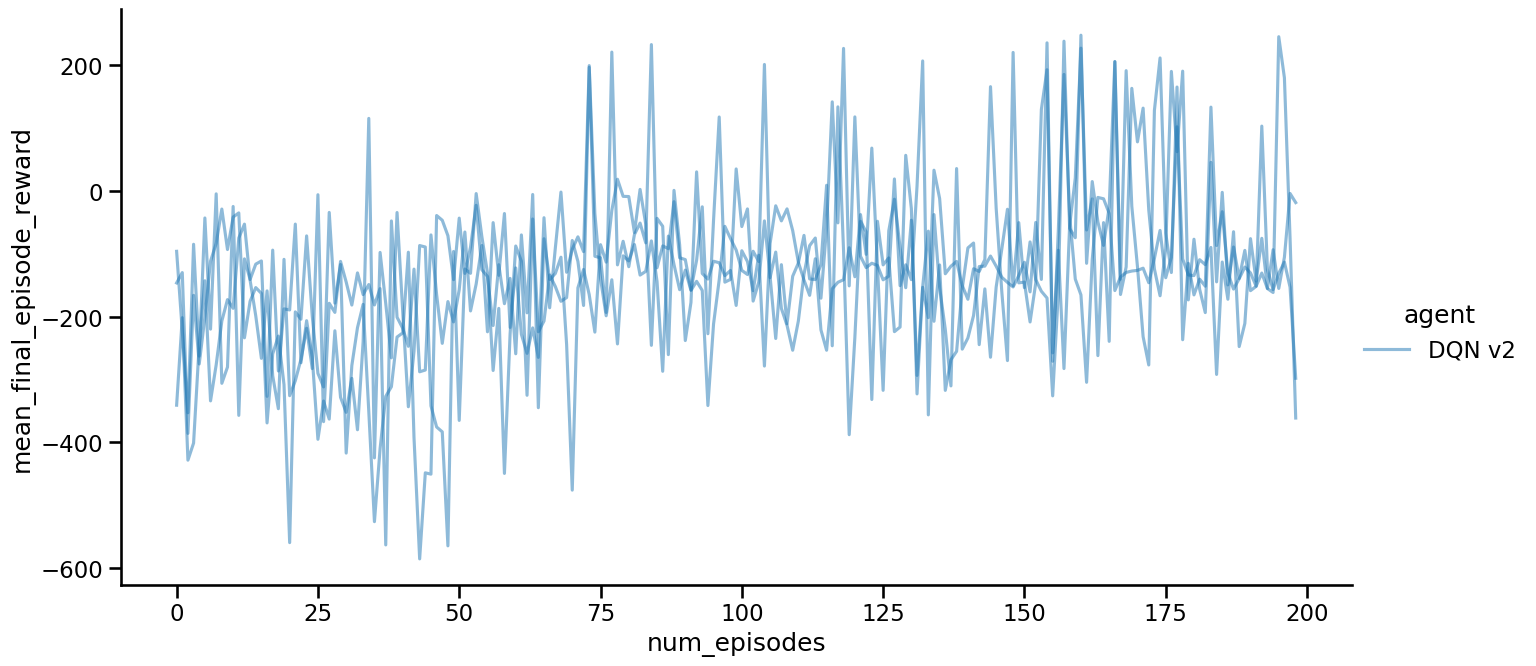

In [57]:
g = sns.relplot(
    x="num_episodes",
    y="mean_final_episode_reward",
    kind="line",
    hue="agent",
    estimator=None,
    units="training_index",
    data=dqn2_trains_result_df,
    height=7,
    aspect=2,
    alpha=0.5,
)
plt.savefig(PLOTS_DIR / "project_dqn2_trains_result.png")

In [58]:
VIDEO_PREFIX_EX4_DQN2_TRAINED = "project_dqn2_tained"

NUM_EPISODES = 3

file_path_list = [
    FIGS_DIR / f"{VIDEO_PREFIX_EX4_DQN2_TRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode = "rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(FIGS_DIR),
    name_prefix=VIDEO_PREFIX_EX4_DQN2_TRAINED,
    episode_trigger=lambda x: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

test_q_network_agent(env, q_network, num_episode=NUM_EPISODES)

# print(f'Episode time taken: {env.time_queue}')
# print(f'Episode total rewards: {env.return_queue}')
# print(f'Episode lengths: {env.length_queue}')

env.close()

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list)

Episode reward: -64.08755268612936
Episode reward: -62.818245830743024
Episode reward: 167.79828506483202

Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(WindowsPath('figs/project/project_dqn2_tained…

<function __main__.video_selector(file_path: List[pathlib.Path])>

In [59]:
score_dqn2 = dqn2_trains_result_df[["num_episodes", "mean_final_episode_reward"]].groupby("num_episodes").mean().max()
score_dqn2

mean_final_episode_reward    110.031064
dtype: float64

## Policy gradient

In [61]:
class PolicyNetwork(torch.nn.Module):
    """
    A neural network used as a policy for the REINFORCE algorithm.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        A fully connected layer.

    Methods
    -------
    forward(state: torch.Tensor) -> torch.Tensor
        Define the forward pass of the PolicyNetwork.
    """

    def __init__(self, dim_observation: int, n_action: int):
        """
        Initialize a new instance of PolicyNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        """
        super().__init__()
        self.layer = torch.nn.Linear(dim_observation, n_action)

    def forward(self, state_tensor: torch.Tensor) -> torch.Tensor:
        """
        Calculate the probability of each action for the given state.

        Parameters
        ----------
        state_tensor : torch.Tensor
            The input tensor (state).
            The shape of the tensor should be (N, dim),
            where N is the number of states vectors in the batch
            and dim is the dimension of state vectors.

        Returns
        -------
        torch.Tensor
            The output tensor (the probability of each action for the given state).
        """
        action_tensor = self.layer(state_tensor)
        out = F.softmax(action_tensor)
        return out

In [78]:
def sample_discrete_action(
    policy_nn: PolicyNetwork, state: np.ndarray
) -> Tuple[int, torch.Tensor]:
    """
    Sample a discrete action based on the given state and policy network.

    This function takes a state and a policy network, and returns a sampled action and its log probability.
    The action is sampled from a categorical distribution defined by the output of the policy network.

    Parameters
    ----------
    policy_nn : PolicyNetwork
        The policy network that defines the probability distribution of the actions.
    state : np.ndarray
        The state based on which an action needs to be sampled.

    Returns
    -------
    Tuple[int, torch.Tensor]
        The sampled action and its log probability.

    """

    # Convert the state into a tensor, specify its data type as float32, and send it to the device (CPU or GPU).
    # The unsqueeze(0) function is used to add an extra dimension to the tensor to match the input shape required by the policy network.
    # state_tensor = TODO...
    state_tensor = torch.tensor(state,dtype = torch.float32, device = device).unsqueeze(0)

    # Pass the state tensor through the policy network to get the parameters of the action probability distribution.
    # actions_probability_distribution_params = TODO...
    actions_probability_distribution_params = policy_nn(state_tensor)

    # Create the categorical distribution used to sample an action from the parameters obtained from the policy network.
    # See https://pytorch.org/docs/stable/distributions.html#categorical
    # actions_probability_distribution = TODO...
    actions_probability_distribution = torch.distributions.categorical.Categorical(probs=actions_probability_distribution_params)

    # Sample an action from the categorical distribution.
    # sampled_action_tensor = TODO...
    sampled_action_tensor = actions_probability_distribution.sample()

    # Convert the tensor containing the sampled action into a Python integer.
    # sampled_action = TODO...
    sampled_action = sampled_action_tensor.item()

    # Calculate the log probability of the sampled action according to the categorical distribution.
    # sampled_action_log_probability = TODO...
    sampled_action_log_probability = actions_probability_distribution.log_prob(sampled_action_tensor)

    # Return the sampled action and its log probability.
    return sampled_action, sampled_action_log_probability

In [66]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode = "rgb_array")

policy_nn = PolicyNetwork(LL_observation_dim, LL_action_number).to(device)

state, info = env.reset()
theta = list(policy_nn.parameters())
action, action_log_probability = sample_discrete_action(policy_nn, state)

print("state:", state)
print("theta:", theta)
print("sampled action:", action)
print("log probability of the sampled action:", action_log_probability)

env.close()

state: [-0.00274925  1.4042091  -0.27849618 -0.29827327  0.00319259  0.0630834
  0.          0.        ]
theta: [Parameter containing:
tensor([[ 0.0735, -0.3063, -0.1908, -0.3269,  0.2547,  0.1227,  0.0670,  0.3405],
        [-0.1152,  0.0438, -0.2209,  0.3508,  0.2483, -0.0268, -0.2285, -0.0671],
        [ 0.3202, -0.1444, -0.3253, -0.3209,  0.0692, -0.0457,  0.0255, -0.0010],
        [-0.0799,  0.1760, -0.1303,  0.2154, -0.3479,  0.2647,  0.2051,  0.0345]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.2177, -0.3470,  0.2172, -0.3287], device='cuda:0',
       requires_grad=True)]
sampled action: 1
log probability of the sampled action: -1.5708401203155518


In [79]:
def sample_one_episode(
    env: gym.Env, policy_nn: PolicyNetwork, max_episode_duration: int
) -> Tuple[List[np.ndarray], List[int], List[float], List[torch.Tensor]]:
    """
    Execute one episode within the `env` environment utilizing the policy defined by the `policy_nn` parameter.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    max_episode_duration : int
        The maximum duration of the episode.

    Returns
    -------
    Tuple[List[np.ndarray], List[int], List[float], List[torch.Tensor]]
        The states, actions, rewards, and log probability of action for each time step in the episode.
    """
    state_t, info = env.reset()

    episode_states = []
    episode_actions = []
    episode_log_prob_actions = []
    episode_rewards = []
    episode_states.append(state_t)

    for t in range(max_episode_duration):

        # Sample a discrete action and its log probability from the policy network based on the current state
        # action_t, log_prob_action_t = TODO...
        action_t,log_prob_action_t = sample_discrete_action(policy_nn, state_t)

        # Execute the sampled action in the environment, which returns the new state, reward, and whether the episode has terminated or been truncated
        # state_t, reward_t, terminated, truncated, info = TODO...
        state_t, reward_t,terminated, truncated, info = env.step(action_t)

        # Check if the episode is done, either due to termination (reaching a terminal state) or truncation (reaching a maximum number of steps)
        done = terminated or truncated

        # Append the new state, action, action log probability and reward to their respective lists

        episode_states.append(state_t)
        episode_actions.append(action_t)
        episode_log_prob_actions.append(log_prob_action_t)
        episode_rewards.append(float(reward_t))

        if done:
            break

    return episode_states, episode_actions, episode_rewards, episode_log_prob_actions

In [68]:
VIDEO_PREFIX_REINFORCE_UNTRAINED = "project_reinforce_untained"

NUM_EPISODES = 3

file_path_list = [
    FIGS_DIR / f"{VIDEO_PREFIX_REINFORCE_UNTRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode = "rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(FIGS_DIR),
    name_prefix=VIDEO_PREFIX_REINFORCE_UNTRAINED,
    episode_trigger=lambda x: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

for episode_index in range(NUM_EPISODES):
    policy_nn = PolicyNetwork(env.observation_space._shape[0], env.action_space.n).to(device) 
    episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env,policy_nn,max_episode_duration = 500) 

print(f"Episode time taken: {env.time_queue}")
print(f"Episode total rewards: {env.return_queue}")
print(f"Episode lengths: {env.length_queue}")

env.close()

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list)

Episode time taken: deque([0.581965, 0.293682, 0.425888], maxlen=3)
Episode total rewards: deque([np.float64(-128.66482135037526), np.float64(-107.91500487028432), np.float64(-170.60665233123873)], maxlen=3)
Episode lengths: deque([113, 65, 99], maxlen=3)

Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(WindowsPath('figs/project/project_reinforce_u…

<function __main__.video_selector(file_path: List[pathlib.Path])>

In [69]:
def avg_return_on_multiple_episodes(
    env: gym.Env,
    policy_nn: PolicyNetwork,
    num_test_episode: int,
    max_episode_duration: int,
) -> float:
    """
    Play multiple episodes of the environment and calculate the average return.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    num_test_episode : int
        The number of episodes to play.
    max_episode_duration : int
        The maximum duration of an episode.

    Returns
    -------
    float
        The average return.
    """

    # TODO...
    average_return = 0.0
    for episode_index in range(num_test_episode):
        episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env,policy_nn,max_episode_duration)
        average_return += sum(episode_rewards)
    average_return /= num_test_episode
    return average_return

In [ ]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode = "rgb_array")

policy_nn = PolicyNetwork(env.observation_space._shape[0], env.action_space.n).to(device)
average_return = avg_return_on_multiple_episodes(env,policy_nn,20,500)

print(average_return)

env.close()

-249.13796576589866


In [ ]:
def train_reinforce_discrete(
    env: gym.Env,
    num_train_episodes: int,
    num_test_per_episode: int,
    max_episode_duration: int,
    learning_rate: float,
) -> Tuple[PolicyNetwork, List[float]]:
    """
    Train a policy using the REINFORCE algorithm.

    Parameters
    ----------
    env : gym.Env
        The environment to train in.
    num_train_episodes : int
        The number of training episodes.
    num_test_per_episode : int
        The number of tests to perform per episode.
    max_episode_duration : int
        The maximum length of an episode, by default EPISODE_DURATION.
    learning_rate : float
        The initial step size.

    Returns
    -------
    Tuple[PolicyNetwork, List[float]]
        The final trained policy and the average returns for each episode.
    """
    episode_avg_return_list = []

    policy_nn = PolicyNetwork(env.observation_space._shape[0], env.action_space.n).to(device)
    optimizer = torch.optim.Adam(policy_nn.parameters(), lr=learning_rate)

    for episode_index in tqdm(range(num_train_episodes)):
        episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env,policy_nn,max_episode_duration)
        T = len(episode_states) - 1
        returns = torch.tensor(episode_rewards, dtype=torch.float32, device=device)  
        returns = returns.flip(dims=(0,)).cumsum(dim=0).flip(dims=(0,))
        for i in range(T):
            loss = -returns[i]*episode_log_prob_actions[i]  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Test the current policy
        test_avg_return = avg_return_on_multiple_episodes(
            env=env,
            policy_nn=policy_nn,
            num_test_episode=num_test_per_episode,
            max_episode_duration=max_episode_duration,
        )

        # Monitoring
        episode_avg_return_list.append(test_avg_return)

    return policy_nn, episode_avg_return_list

In [ ]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode = "rgb_array")

NUMBER_OF_TRAININGS = DEFAULT_NUMBER_OF_TRAININGS  # Change the default (global) value here if you want a specific number of trainings for this exercise
reinforce_trains_result_list: List[List[Union[int, float]]] = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    # Train the agent
    reinforce_policy_nn, episode_reward_list = train_reinforce_discrete(
        env=env,
        num_train_episodes=200,
        num_test_per_episode=5,
        max_episode_duration=500,
        learning_rate=0.01,
    )

    reinforce_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_trains_result_list[1].extend(episode_reward_list)
    reinforce_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_trains_result_df = pd.DataFrame(
    np.array(reinforce_trains_result_list).T,
    columns=["num_episodes", "mean_final_episode_reward", "training_index"],
)
reinforce_trains_result_df["agent"] = "REINFORCE"

# Save the action-value estimation function of the last train

torch.save(reinforce_policy_nn, MODELS_DIR / "project_reinforce_policy_network.pth")

env.close()

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

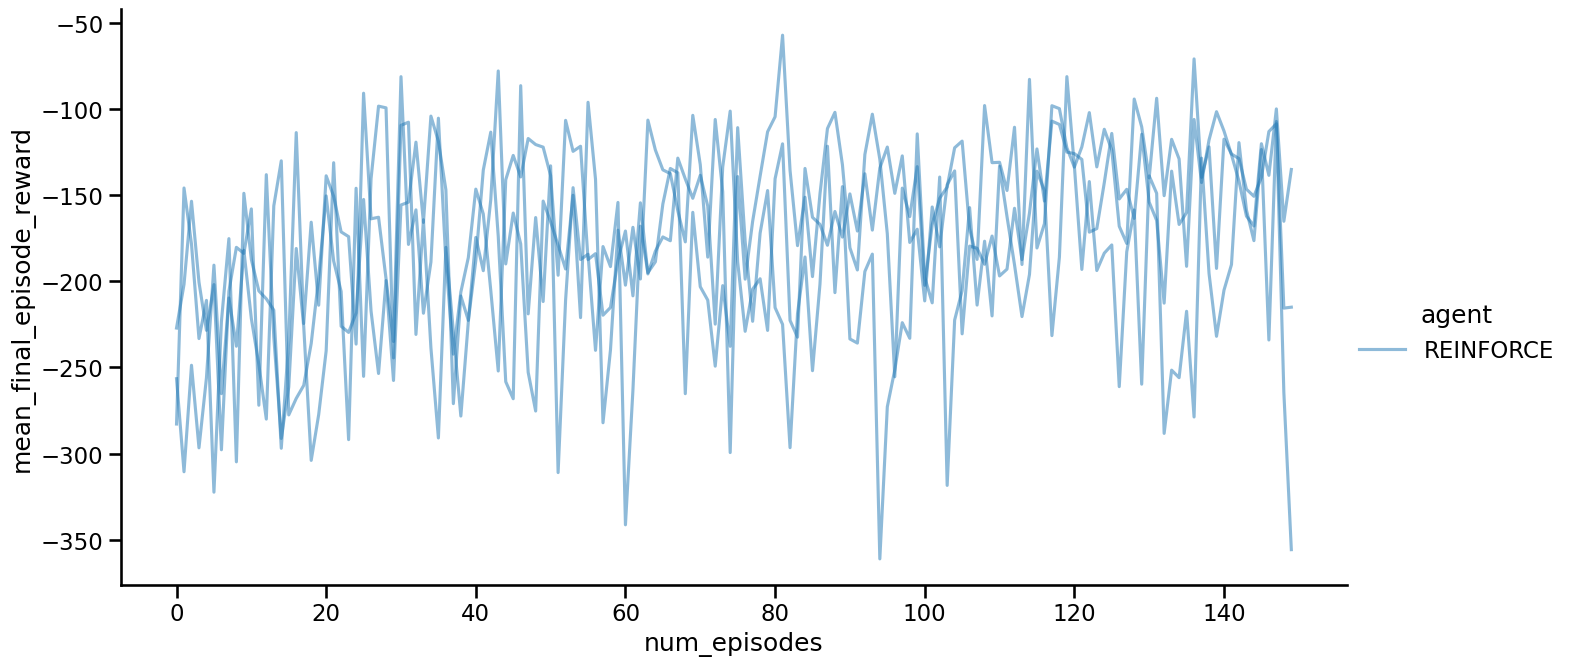

In [82]:
g = sns.relplot(
    x="num_episodes",
    y="mean_final_episode_reward",
    kind="line",
    hue="agent",
    estimator=None,
    units="training_index",
    data=reinforce_trains_result_df,
    height=7,
    aspect=2,
    alpha=0.5,
)
plt.savefig(PLOTS_DIR / "project_reinforce_trains_result.png")

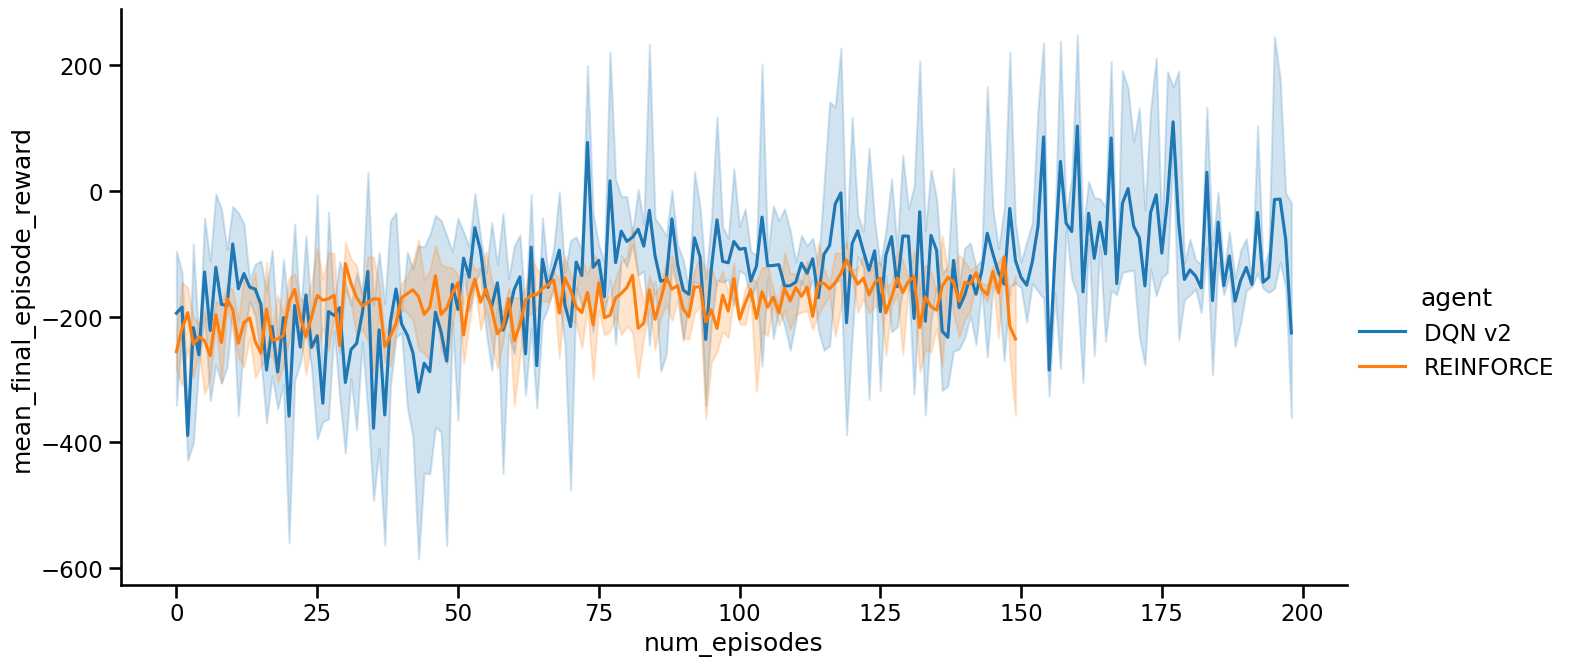

In [83]:
all_trains_result_df = pd.concat(
    [
        dqn2_trains_result_df,
        reinforce_trains_result_df,
    ]
)
g = sns.relplot(
    x="num_episodes",
    y="mean_final_episode_reward",
    kind="line",
    hue="agent",
    data=all_trains_result_df,
    height=7,
    aspect=2,
)
plt.savefig(PLOTS_DIR / "project_reinforce_trains_result_agg.png")

In [87]:
VIDEO_PREFIX_PROJECT_REINFORCE_TRAINED = "project_reinforce_tained"

NUM_EPISODES = 3

file_path_list = [
    FIGS_DIR / f"{VIDEO_PREFIX_PROJECT_REINFORCE_TRAINED}-episode-{episode_index}.mp4"
    for episode_index in range(NUM_EPISODES)
]

for file_path in file_path_list:
    file_path.unlink(missing_ok=True)

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode = "rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder=str(FIGS_DIR),
    name_prefix=VIDEO_PREFIX_PROJECT_REINFORCE_TRAINED,
    episode_trigger=lambda x: True,
)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=NUM_EPISODES)

max_episode_duration = 500
for episode_index in range(NUM_EPISODES):
    state_t, info = env.reset()
    episode_states = []
    episode_actions = []
    episode_rewards = []
    episode_states.append(state_t)

    for t in range(max_episode_duration):
        state_tensor_t = torch.tensor(state_t,dtype = torch.float32, device = device).unsqueeze(0)
        actions_probability_distribution_params = reinforce_policy_nn(state_tensor_t)
        action_t = torch.argmax(actions_probability_distribution_params).item()
        state_t, reward_t,terminated, truncated, info = env.step(action_t)
        done = terminated or truncated
        episode_states.append(state_t)
        episode_actions.append(action_t)
        episode_rewards.append(float(reward_t))
        if done:
            break
    
print(f"Episode time taken: {env.time_queue}")
print(f"Episode total rewards: {env.return_queue}")
print(f"Episode lengths: {env.length_queue}")

env.close()

print("\nSelect the episode to play here 👇\n")

interact(video_selector, file_path=file_path_list)

Episode time taken: deque([0.411883, 0.255465, 0.258062], maxlen=3)
Episode total rewards: deque([np.float64(-299.58273149162426), np.float64(-123.89281335214932), np.float64(-346.3251770524196)], maxlen=3)
Episode lengths: deque([105, 66, 85], maxlen=3)

Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(WindowsPath('figs/project/project_reinforce_t…

<function __main__.video_selector(file_path: List[pathlib.Path])>